Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
!pip install sweetviz

     |████████████████████████████████| 327kB 5.6MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 3.3MB/s 


In [ ]:
# We'll upload our file to our google colab
from google.colab import files
uploaded = files.upload()


Saving final_dataset_form.csv to final_dataset_form (1).csv


In [ ]:
# Import pandas and io, make our dataset
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['final_dataset_form.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
# Let's take a look at df
df.head()

,Unnamed: 0,Dependent-Company Status,year of founding,Internet Activity Score,Focus functions of company,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Amount,Country of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",Number of of Partners of company,Crowdsourcing based business,Crowdfunding based business,Machine Learning based business,Predictive Analytics business,...,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score,Market Research,Marketing,Analytics,Software Development,Mobile,Enterprise Software,Media,Cloud Computing,Network / Hosting / Infrastructure,Social Networking,Retail,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,0,Success,NaN,-1.0,operation,3.0,0.0,No,NaN,450000.0,United States,2.0,0.0,1,2,2,Yes,4.0,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,None,No,No,No,No,...,No,No,No,NaN,9626884.0,No,Yes,No,2.0,Low,0.0,1.500000,0.45,NaN,NaN,11.560000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Success,2011.0,125.0,"Marketing, sales",NaN,NaN,No,NaN,NaN,United States,5.0,0.0,2,0,4,No,0.0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,Few,Yes,No,Yes,Yes,...,No,No,Yes,Medium,1067034.0,Yes,Yes,No,3.0,Medium,0.0,6.666667,5,Not Applicable,10.0,9.000000,Trough,2 to 5,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Success,2011.0,455.0,operations,14.0,0.0,No,12/1/2011,2350000.0,United States,15.0,0.0,3,0,7,No,0.0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,No,Few,No,No,No,Yes,...,No,No,No,Low,71391.0,Yes,Yes,Yes,3.0,Medium,0.0,3.333333,2.35,Not Applicable,2.0,7.344444,Trough,2 to 5,9.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Success,2009.0,-99.0,Marketing & Sales,45.0,10.0,No,6/20/2009,10250000.0,United States,6.0,0.0,2,0,4,Yes,0.0,low,No,Large,Yes,Yes,No,No,Product,Yes,Public,Yes,Structured,Yes,Platform,Local,Non-Linear,No,Few,Yes,No,No,No,...,No,No,No,Low,11847.0,No,Yes,Yes,4.0,Medium,2.0,10.000000,10.25,Not Applicable,1.0,8.700000,Trough,2 to 5,5.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Success,2010.0,496.0,Marketing & Sales,39.0,3.0,No,4/1/2

In [ ]:
# We'll drop both the duplicated index column and the year of founding column, since it's already represented by the Est. founding date
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('year of founding', axis=1, inplace=True)

In [ ]:
import sweetviz as sv

# sweet_report = sv.analyze(df)

# sweet_report.show_html('sweet_report.html')

In [ ]:
df.dtypes

Dependent-Company Status       object
Internet Activity Score       float64
Focus functions of company     object
Employee Count                float64
Employees count MoM change    float64
                               ...   
Music                         float64
Publishing                    float64
Gaming                        float64
Email                         float64
Career / Job Search           float64
Length: 113, dtype: object

In [ ]:
# Separate our X and Y
X = df.drop('Dependent-Company Status', axis=1)
y = df['Dependent-Company Status']

In [ ]:
print("Our baseline is: ", y.value_counts(normalize=True).max())

Our baseline is:  0.6461864406779662


In [ ]:
# import libraries for pipeline 
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Make the pipeline
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

In [ ]:
#Import kfold cross valdiation
from sklearn.model_selection import KFold, cross_val_score 

In [ ]:
# See our cross validation score
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=11)

cv_scores = cross_val_score(model, X, y,
                           cv=kfold_cv, scoring='accuracy')

# Print the mean score
print('All cv scores: ', cv_scores)

# Print the mean score
print('Mean of all cv scores: ', cv_scores.mean())

All cv scores:  [0.90526316 0.93684211 0.9893617  0.89361702 0.89361702]
Mean of all cv scores:  0.923740201567749


In [ ]:
# Import train test split
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Fit our data
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of  Sales Support material',
                                      'Worked in top companies',
                                      'Average size of companies worked for in '
                                      'the past',
                                      'Have been part of startups in the past?'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytr

<Figure size 576x576 with 0 Axes>

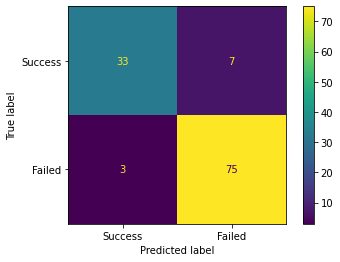

In [ ]:
# Plot a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(model, X_test, y_test,
                      display_labels=['succeeded', 'Failed'],
                      )

fig.clf()

In [ ]:
# Check our metrics
print('Training Accuracy:', model.score(X_train, y_train))
print('Test Accuracy:', model.score(X_test, y_test))

Training Accuracy: 1.0
Validation Accuracy: 0.9152542372881356


In [ ]:
# Import metrics
from sklearn import metrics

In [ ]:
# See our precision and recall
y_pred = model.predict(X_test)
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Failed       0.92      0.82      0.87        40
     Success       0.91      0.96      0.94        78

    accuracy                           0.92       118
   macro avg       0.92      0.89      0.90       118
weighted avg       0.92      0.92      0.91       118



In [ ]:
# See our XGBoost feature importances
from xgboost import plot_importance

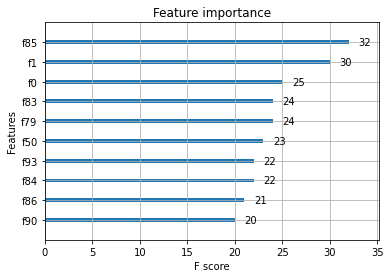

In [ ]:
# Plot feature importances
import matplotlib.pyplot as plt

plot_importance(model[2], max_num_features=10)
plt.show()

XGBoost features are not good for feature importance. So we'll train a random forest classifier.

In [ ]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Make the model
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

In [ ]:
# Fit our model
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of  Sales Support material',
                                      'Worked in top companies',
                                      'Average size of companies worked for in '
                                      'the past',
                                      'Have been part of startups in the past?'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                  

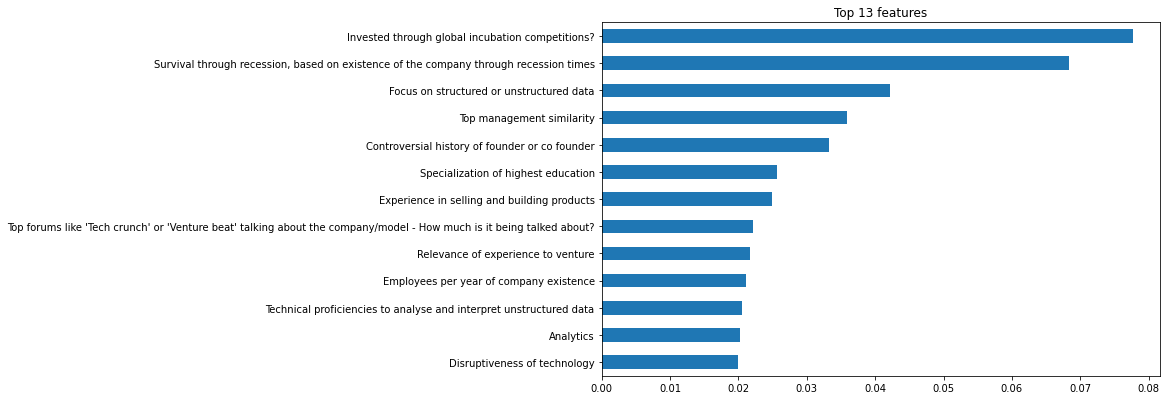

In [ ]:
# Plot the feature importances
import matplotlib.pyplot as plt

importances = pd.Series(model[2].feature_importances_, X.columns)

# Plot top n feature importances
n = 13
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh()

plt.show()


In [ ]:
# Permute the values in a less important column
feature = 'Employees per year of company existence'

X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model.score(X_test, y_test))
print('Validation Accuracy (permuted)', model.score(X_test_permuted, y_test))

Feature permuted:  Employees per year of company existence
Validation Accuracy 0.9067796610169492
Validation Accuracy (permuted) 0.8983050847457628
